# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

***Цель исследования:***   
Спрогнозировать, уйдёт клиент из банка в ближайшее время или нет на основе исторических данных о поведении клиентов и расторжении договоров с банком, построить модель с предельно большим значением *F1*-меры. Преодолеть порог 0.59 на тестовой выборке



***План работы:***  
* Загрузить и подготовить данные.  
* Исследовать баланс классов, обучить модель без учёта дисбаланса.  
* Улучшить качество модели, учитывая дисбаланс классов. Обучить разные модели и найти лучшую.  
* Провести финальное тестирование.  
  

***Описание данных***  
  
RowNumber — индекс строки в данных  
CustomerId — уникальный идентификатор клиента  
Surname — фамилия  
CreditScore — кредитный рейтинг  
Geography — страна проживания  
Gender — пол  
Age — возраст  
Tenure — сколько лет человек является клиентом банка  
Balance — баланс на счёте  
NumOfProducts — количество продуктов банка, используемых клиентом  
HasCrCard — наличие кредитной карты  
IsActiveMember — активность клиента  
EstimatedSalary — предполагаемая зарплата  

**Целевой признак**  
  

Exited — факт ухода клиента  

## Подготовка данных

### Просмотр

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))


In [2]:
try:
    df = pd.read_csv("D:/practicum/datasets_for_projects/Churn.csv")
except:
    print("датасет отсутствует")

df.info()
display(df.head())
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


0

### Вывод

* Мы имеем таблицу из 13 столбцов и 10000 строк. названия в верблюжем регистре. Приведем к змеиному.  
* 3 первых признака не имеют предсказательного смысла. удалим столбцы.  
* Так же имеются 2 строковые переменные. Закодируем их при помощи метода One Hot Encoding.  
* Явных дубликатов нет.  
* В одном из столбцов присутствуют пропуски. попробуем их обработать на следующем этапе.  


## Предобработка

In [3]:
# Приводим названия столбцов к змеиному регистру
columns = []
for name in df.columns:
    new_name = ""
    for i in name:
        if i.isupper():
            new_name += "_" + i.lower()
        else:
            new_name += i
    new_name = new_name[1:]    
    columns.append(new_name)    

df.columns = columns
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
# проверяем дубликаты среди идентификаторов
display(df["customer_id"].duplicated().sum())

0

все значения в столбце с идентификатором клиента уникальны, значит дубликатов нет

Удалим бесполезные признаки

In [5]:
df = df.drop(["row_number", "customer_id", "surname"], axis=1)

Посмотрим на распределение значений численых признаков

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


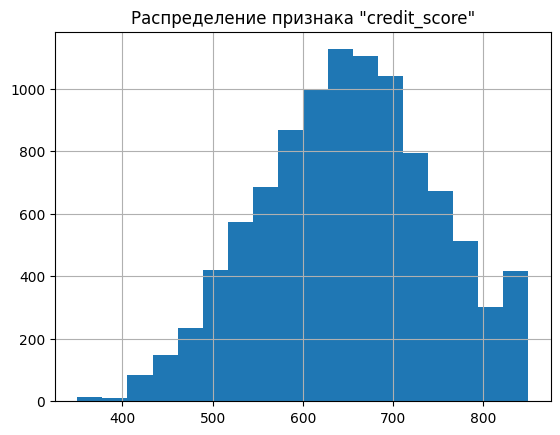

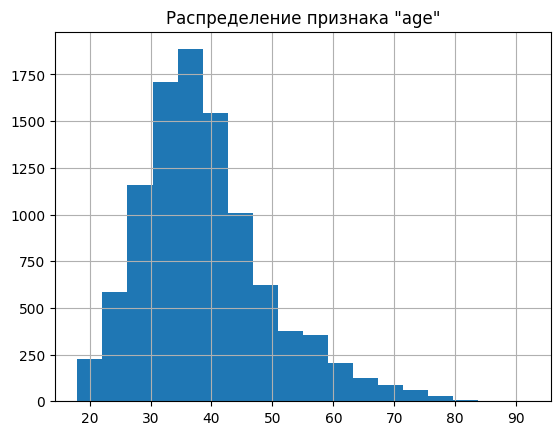

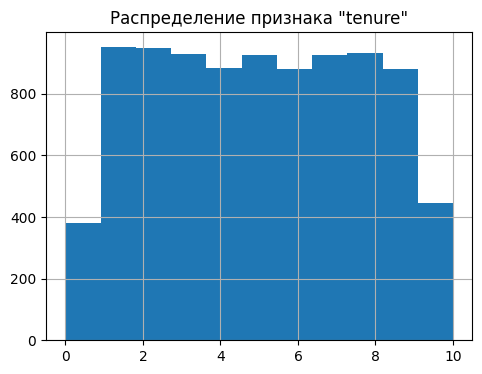

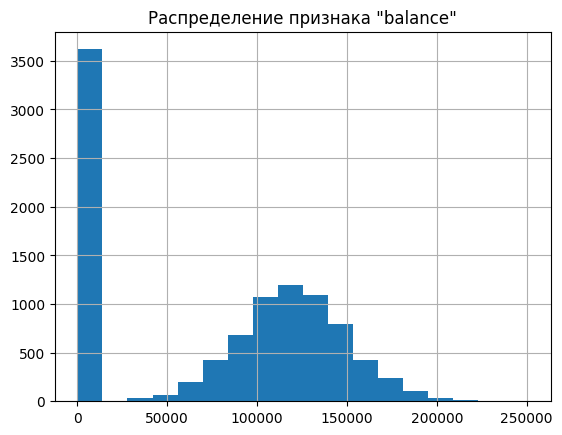

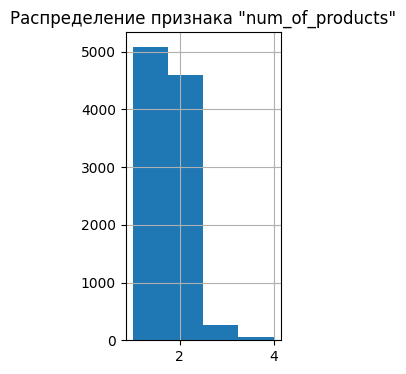

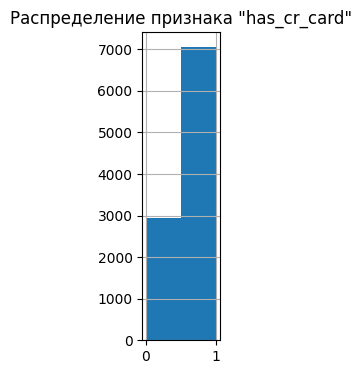

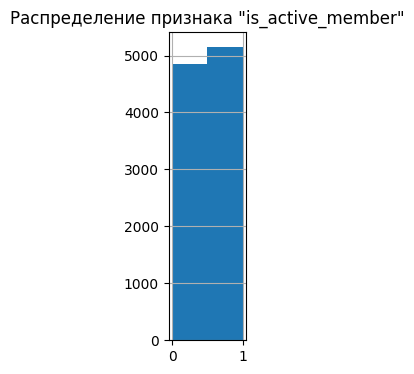

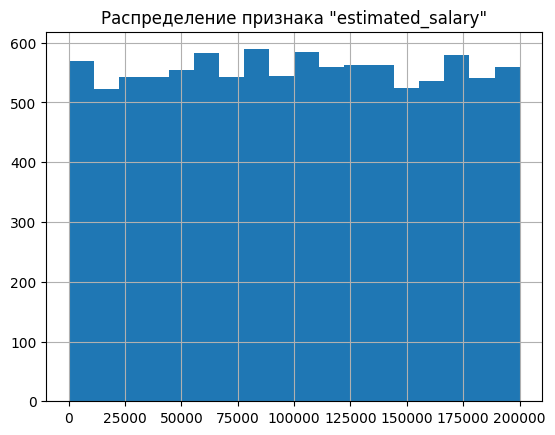

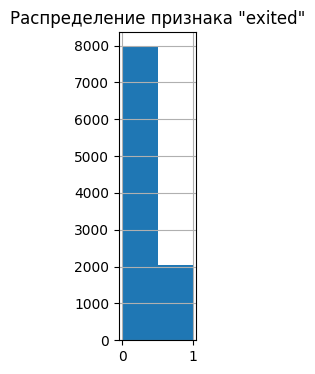

In [6]:
numeric = ["credit_score", 
           "age", 
           "tenure", 
           "balance", 
           "num_of_products", 
           "has_cr_card", 
           "is_active_member", 
           "estimated_salary", 
           "exited"]
display(df.describe())
for column in numeric:
    x = len(df[column].value_counts()) 
    if x <= 20:
        plt.figure(figsize=(x/2, 4))
        df[column].hist(bins=x)
    else:
        plt.figure()
        df[column].hist(bins=18)
    plt.title(f"Распределение признака \"{column}\"")
    plt.show()

* распределение кредитного рейтинга стремится к нормальному. Присутствует небольшой всплеск на максимальных значениях.  
* Распределение по возрасту так же стремится к нормальному есть скошенность вправо. в районе максимальных значений 80-90 лет присутствуют редкие значения по понятным причинам. Данные выглядят достоверно. 
* В распределении баланса счета есть пик на нуле. Вероятно многие клиенты имеют карту, но не пользуются ею. Нули всречаются как у ушедших клиентов так и у действующих, та же картина с положительным балансом. Не считая нулевого всплеска, распределение нормальное.
* Количество лет пользования услугами распределено равномерно, не считая провалов на минимальном и максимальном значениях 0, 10лет. 
* Предполагаемая зарплата распределена равномерно
* В целом данные выглядят правдоподобно, без серьезных аномалий.
* В целевом признаке присутствует ощутимый дисбаланс классов.

In [7]:
# смотрим как распределились строковые значения
display(df["gender"].value_counts())
df["geography"].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

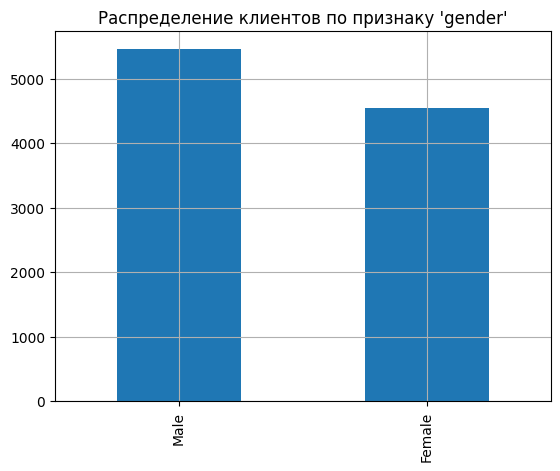

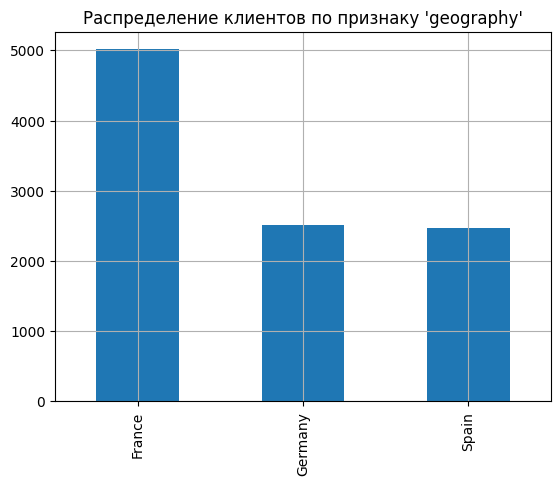

In [8]:
plt.figure()
plt.title("Распределение клиентов по признаку 'gender'")
df["gender"].value_counts().plot.bar()
plt.grid()
plt.figure()
plt.title("Распределение клиентов по признаку 'geography'")
df["geography"].value_counts().plot.bar()
plt.grid()
plt.show()

* Женщин немного меньше, чем мужчин
* Во Франции клиентов в 2 раза больше, чем в других странах 

In [9]:
# доля пропусков в столбце с длительностнью пользования услугами банка
display(df["tenure"].isna().mean())
df[df["tenure"].isna()].head(20)

0.0909

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


9 процентов. 

### Вывод

По итогам предобработки закономерностей в данных с пропусками не выявлено. Рассматриваемый признак имеет достаточно случайную природу, и связать его с другими признаками для корректного заполнения данных  не представляется возможным. Других серьезных проблем в данных не обнаружено

## Исследование задачи

Мы имеем задачу бинарной классификации.  
Целевой признак - Exited.  
Рассмотрим столбец с пропусками более пристально (количество лет пользования услугами банка).  
Посмотрим присутствует ли корреляция между этим признаком и целевым.  
Для полноты картины взглянем и на корреляцию с прочими численными признаками 

In [10]:
df.corr()["exited"]

C:\Users\Pasha\AppData\Local\Temp\ipykernel_4700\3832204202.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()["exited"]


credit_score       -0.027094
age                 0.285323
tenure             -0.016761
balance             0.118533
num_of_products    -0.047820
has_cr_card        -0.007138
is_active_member   -0.156128
estimated_salary    0.012097
exited              1.000000
Name: exited, dtype: float64

все признаки очень слабо коррелируют с целевым. Одно из наиболее низких значений корреляции у признака, по которому отсутствует часть данных.

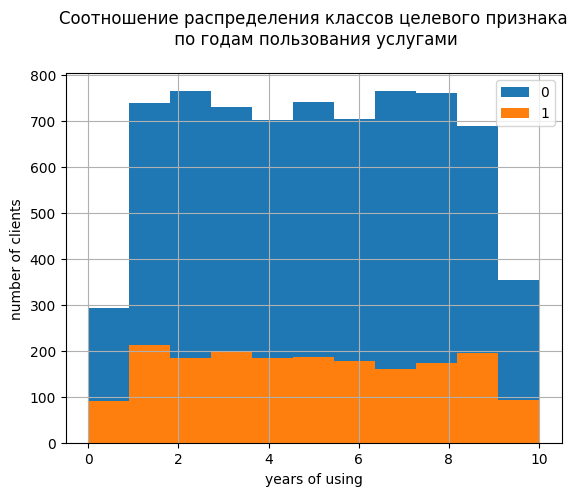

In [11]:
df.groupby("exited")["tenure"].hist(bins=11)
plt.title("Соотношение распределения классов целевого признака\n по годам пользования услугами\n")
plt.xlabel("years of using")
plt.ylabel("number of clients")
plt.legend("01")
plt.show()

In [12]:
# посмотрим на цифры

p = df.pivot_table(index="tenure", values="exited", aggfunc= ["sum", "mean"])
p.columns = ["кол-во ушедших", "доля ушедших"]
p

,кол-во ушедших,доля ушедших
tenure,,
0.0,90,0.235602
1.0,213,0.223739
2.0,185,0.194737
3.0,198,0.213362
4.0,184,0.207910
5.0,187,0.201726
6.0,177,0.200908
7.0,160,0.172973
8.0,174,0.186495


соотношение распределилось достаточно равномерно доля ушедших среди групп находится в диапазоне от 17 до 23%. Закономерно сделать предположение, что данный признак может не иметь большого значения для модели. соответственно исходя из данной гипотизы, найдем лучшие модели для 2 выборок:
1. без строк с пропусками
2. без столбца с пропусками

Посмотрим на баланс классов

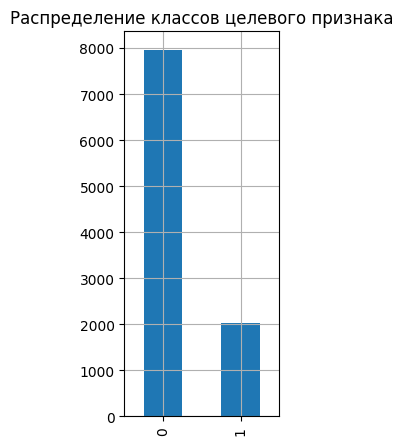

0    7963
1    2037
Name: exited, dtype: int64

доля ушедших:


0.2037

In [13]:
plt.figure(figsize=(2, 5))
plt.title("Распределение классов целевого признака")
df["exited"].value_counts().plot.bar()
plt.grid()
plt.show()
display(df["exited"].value_counts())
print("доля ушедших:")
df["exited"].mean()

Дисбаланс классов на лицо.

Закодируем строковые категориальные признаки

In [14]:
# прямое кодирование
df = pd.get_dummies(df, drop_first=True)
df.columns = df.columns.str.lower()
df.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Масштабируем все признаки, кроме бинарных, чтобы они воспринимались моделью как равнозначные

In [15]:
scaler = MinMaxScaler()
not_binary = ["credit_score", "age", "tenure", "balance", "num_of_products", "estimated_salary"]
df[not_binary] = scaler.fit_transform(df[not_binary])
df[not_binary].head()


,credit_score,age,tenure,balance,num_of_products,estimated_salary
0,0.538,0.324324,0.2,0.000000,0.000000,0.506735
1,0.516,0.310811,0.1,0.334031,0.000000,0.562709
2,0.304,0.324324,0.8,0.636357,0.666667,0.569654
3,0.698,0.283784,0.1,0.000000,0.333333,0.469120
4,1.000,0.337838,0.2,0.500246,0.000000,0.395400


In [16]:
df.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,0.538,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1,0,0,0
1,0.516,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0,0,1,0
2,0.304,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1,0,0,0
3,0.698,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0,0,0,0
4,1.000,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0,0,1,0


## Подбор модели без столбца Tenure

In [17]:
# выделяем целевой признак
features = df.drop(["exited", "tenure"], axis=1)
target = df["exited"]
# разбиваем выборку на 3 части, применяя стратификацию
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=12345, stratify=y_valid)
print("ok")


ok


### Логистическая регрессия

In [18]:
model = LogisticRegression(random_state=12345, solver="liblinear")
# обучение
model.fit(X_train, y_train)
predictions = model.predict(X_valid)
print(f1_score(y_valid, predictions))

0.3054003724394786


Слишком низкий показатель F1-меры. Очевидно, алгоритм логистической регрессии не подходит для нашей задачи. оптимизировать модель не вижу смысла.

In [19]:
# создаем список для результатов
final_list = []

### Дерево решений

In [20]:
def tree_opt(depth_min, depth_max, weight=None, with_tenure=False):
    """функция перебирает значения глубины дерева решений и 
    возвращает модель с наибольшим значением f1,   
    вывдя на дисплей данные по ней"""
    result_list = ["Decision Tree"]
    best_model = None
    best_depth = 0
    best_f1 = 0
    for depth in range (depth_min, depth_max):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight=weight)
        model.fit(X_train, y_train)
        predictions = model.predict(X_valid)
        f1 = f1_score(y_valid, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
            best_depth = depth
    print(f"f1 = {best_f1}, глубина = {best_depth}")
    probabilities = best_model.predict_proba(X_valid)
    probabilities_one = probabilities[:, 1]
    best_roc_auc = roc_auc_score(y_valid, probabilities_one)
    print(f"auc roc = {best_roc_auc}")
    result_list.append(with_tenure)
    result_list.append(best_depth)
    result_list.append("---------")
    result_list.append(best_f1)
    result_list.append(best_roc_auc)
    if weight:
        result_list.append(weight)
    else:
        result_list.append("---------")
    result_list.append("---------")
    final_list.append(result_list)
    return best_model

In [21]:
%%time
best_tree = tree_opt(1, 100)

f1 = 0.5939741750358679, глубина = 7
auc roc = 0.8268186828751601
CPU times: total: 2.09 s
Wall time: 2.09 s


Лучший результат получен при глубине равной 7/ Значение f1 немного выше заданного порога. посмотрим, как модель отреагирует на балансировку классов.

In [22]:
%%time
best_tree_balanced = tree_opt(1, 100, "balanced")

f1 = 0.5753931544865865, глубина = 6
auc roc = 0.8235925337471672
CPU times: total: 2.91 s
Wall time: 2.9 s


значение f1 уменьшилось

### Случайный лес

In [23]:
# лес
def forest_opt(est_min, est_max, step, depth_min, depth_max, weight=None, with_tenure=False):
    """функция  получает на вход минимальные и максимальные значения количества 
    и глубины деревьев случайного леса, и возвращает модель с наибольшим значением f1,
    и выводит на дисплей данные по ней"""
    result_list = ["Random Forest"]
    best_f1 = 0
    best_model = None
    best_est = 0
    best_depth = 0
    for est in range(est_min, est_max, step):
        for depth in range(depth_min, depth_max):
            model = RandomForestClassifier(random_state=12345,max_depth=depth, n_estimators=est, class_weight=weight)
            model.fit(X_train, y_train)
            predictions = model.predict(X_valid)
            f1 = f1_score(y_valid, predictions)
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_est = est
                best_depth = depth
            
    print(f"f1 {best_f1}, кол-во деревьев {best_est}, глубина {best_depth}")
    probabilities = best_model.predict_proba(X_valid)
    probabilities_one = probabilities[:, 1]
    best_roc_auc = roc_auc_score(y_valid, probabilities_one)
    print(f"auc roc = {best_roc_auc}")
    result_list.append(with_tenure)
    result_list.append(best_depth)
    result_list.append(best_est)
    result_list.append(best_f1)
    result_list.append(best_roc_auc)
    if weight:
        result_list.append(weight)
    else:
        result_list.append("---------")
    result_list.append("---------")
    final_list.append(result_list)
    return best_model

In [24]:
%%time
best_forest = forest_opt(1, 101, 10, 1, 20)

f1 0.6244477172312224, кол-во деревьев 61, глубина 13
auc roc = 0.8611447248497389
CPU times: total: 48.7 s
Wall time: 48.9 s


Мы получили достаточно высокое значение f1. Попытаемся улучшить модель. сузим диапазон и уменьшим шаг для количества деревьев

In [25]:
%%time
best_forest = forest_opt(52, 70, 1, 11, 15)


f1 0.629575402635432, кол-во деревьев 65, глубина 13
auc roc = 0.861322544093014
CPU times: total: 29.9 s
Wall time: 30 s


Метрика еще немного увеличилась

### Борьба с дисбалансом 

сбалансируем классы

In [27]:
%%time
best_forest_balanced = forest_opt(52, 70, 1, 6, 10, "balanced")

f1 0.6510067114093959, кол-во деревьев 63, глубина 8
auc roc = 0.8712627167701251
CPU times: total: 20.8 s
Wall time: 20.9 s


Снова наблюдается рост целевой метрики качества. значение roc-auc так же возрасло.
Подберем порог для несбалансированной модели

In [28]:
def best_forest_threshold(forest, with_tenure=False):
    """функция принимает на вход обученную модель и возвращает значения 
    метрик качества при разных порогах, а так же лучшие показатели f1"""
    result_list = ["Random Forest"]
    probabilities = forest.predict_proba(X_valid)
    probabilities_one = probabilities[:, 1]
    best_roc_auc = roc_auc_score(y_valid, probabilities_one)
    best_f1 = 0
    best_threshold = 0
    for threshold in np.arange(0, 1, 0.1):
        predictions = probabilities_one > threshold
        precision = precision_score(y_valid, predictions)
        recall = recall_score(y_valid, predictions)
        f1 = f1_score(y_valid, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
        print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, f1 = {:.5f}".format(threshold, precision, recall, f1))
    print("лучший порог:", best_threshold, "лучшее значение f1:", best_f1)
    print(f"auc roc = {best_roc_auc}")
    result_list.append(with_tenure)
    result_list.append(forest.max_depth)
    result_list.append(forest.n_estimators)
    result_list.append(best_f1)
    result_list.append(best_roc_auc)
    result_list.append("---------")
    result_list.append(best_threshold)
    final_list.append(result_list)
    print(result_list)
    
    

In [29]:
%%time
best_forest_threshold(best_forest)

Порог = 0.00 | Точность = 0.204, Полнота = 1.000, f1 = 0.33887
Порог = 0.20 | Точность = 0.483, Полнота = 0.767, f1 = 0.59280
Порог = 0.40 | Точность = 0.699, Полнота = 0.591, f1 = 0.64011
Порог = 0.60 | Точность = 0.833, Полнота = 0.429, f1 = 0.56634
Порог = 0.80 | Точность = 0.880, Полнота = 0.270, f1 = 0.41276
лучший порог: 0.4 лучшее значение f1: 0.6401062416998673
auc roc = 0.861322544093014
['Random Forest', False, 13, 65, 0.6401062416998673, 0.861322544093014, '---------', 0.4]
CPU times: total: 31.2 ms
Wall time: 29.4 ms


### Вывод

Для лучшей модели случайного леса с несбалансированными классами найден порог при котором значение метрики качества достигает достаточно высокого значения, но более сильного эффекта мы добились при балансировке классов. 

## Подбор модели без строк с пропусками

Проделаем все те же манипуляции для выборки без строк с пропусками

In [30]:
# удаляем строки с пропусками
df_drop_rows = df.dropna()
df_drop_rows.shape

(9091, 12)

In [31]:
# деление на выборки
features = df_drop_rows.drop("exited", axis=1)
target = df_drop_rows["exited"]
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)
X_valid, X_test_t, y_valid, y_test_t = train_test_split(X_valid, y_valid, test_size=0.5, random_state=12345, stratify=y_valid)

print("ok")

ok


### Логистическая регрессия

In [32]:
model = LogisticRegression(random_state=12345, solver="liblinear")
model.fit(X_train, y_train).get_params()
predictions = model.predict(X_valid)
print("f1", f1_score(y_valid, predictions))

f1 0.3073770491803279


слишком низкое значение, дальнейшая оптимизация бессмысленна

### Дерево решений

In [33]:
best_tree_drop_rows = tree_opt(1, 20, None, True)

f1 = 0.5815126050420169, глубина = 7
auc roc = 0.8245379882534177


In [34]:
# дерево со сбалансированными классами
best_tree_drop_rows_balanced = tree_opt(1, 20, "balanced", True)

f1 = 0.583084577114428, глубина = 6
auc roc = 0.8353643657199484


балансировка классов немного увеличивает значения основных метрик качества

### Случайный лес

In [35]:
best_forest_drop_rows = forest_opt(1, 101, 10, 1, 20, None, True)

f1 0.6256077795786061, кол-во деревьев 51, глубина 19
auc roc = 0.8659816666883988


In [36]:
# уменьшаем диапазон и шаг кол-ва деревьев
best_forestdrop_rows = forest_opt(42, 60, 1, 17, 22, None, True)

f1 0.6258064516129033, кол-во деревьев 55, глубина 19
auc roc = 0.8670713829337398


для второй выборки все значения метрик качества ниже, чем для первой

### Борьба с дисбалансом 2

In [38]:
# балансируем классы
best_forest_drop_rows_balanced = forest_opt(30, 60, 1, 7, 11, "balanced", True)

f1 0.6420382165605096, кол-во деревьев 63, глубина 9
auc roc = 0.8744926299789322


In [39]:
# оптимизация подбором порога
best_forest_threshold(best_forest_drop_rows, True)

Порог = 0.00 | Точность = 0.220, Полнота = 0.997, f1 = 0.36010
Порог = 0.20 | Точность = 0.464, Полнота = 0.792, f1 = 0.58507
Порог = 0.40 | Точность = 0.686, Полнота = 0.606, f1 = 0.64378
Порог = 0.60 | Точность = 0.850, Полнота = 0.412, f1 = 0.55535
Порог = 0.80 | Точность = 0.926, Полнота = 0.202, f1 = 0.33186
лучший порог: 0.4 лучшее значение f1: 0.6437768240343348
auc roc = 0.8659816666883988
['Random Forest', True, 19, 51, 0.6437768240343348, 0.8659816666883988, '---------', 0.4]


значение f1 для случайного леса при сбалансированных классах совсем немного выше, чем значение при оптимальном пороге

In [40]:
# результаты
fl = pd.DataFrame(final_list, columns=["model_name", 
                                       "with_tenure", 
                                       "depth", 
                                       "n_estimators", 
                                       "f1", 
                                       "roc_auc", 
                                       "weight", 
                                       "threshold"])
fl.sort_values("f1", ascending=False)

,model_name,with_tenure,depth,n_estimators,f1,roc_auc,weight,threshold
5,Random Forest,False,8,63,0.651007,0.871263,balanced,---------
4,Random Forest,False,8,81,0.650954,0.872085,balanced,---------
11,Random Forest,True,9,41,0.648030,0.872162,balanced,---------
13,Random Forest,True,19,51,0.643777,0.865982,---------,0.4
12,Random Forest,True,9,63,0.642038,0.874493,balanced,---------
6,Random Forest,False,13,65,0.640106,0.861323,---------,0.4
3,Random Forest,False,13,65,0.629575,0.861323,---------,---------
10,Random Forest,True,19,55,0.625806,0.867071,---------,---------
9,Random Forest,True,19,51,0.625608,0.865982,---------,---------
2,Random Forest,False,13,61,0.624448,0.861145,---------,---------


### Тестирование лучшей модели

In [42]:
# проверяем лучшую модель на тестовой выборке
predictions = best_forest_balanced.predict(X_test)
print(f1_score(y_test, predictions))

0.6112359550561798


In [41]:
# проверяем лучшую модель для выборки со столбцом tenure
predictions = best_forest_drop_rows_balanced.predict(X_test_t)
print(f1_score(y_test_t, predictions))

0.5978835978835979


## ВЫВОД

Было проведено исследование на предмет поиска наиболее подходящей модели машинного обучения. В ходе исследования было протестировано 3 различных типа моделей на двух выборках. Наибольшее значение метрики F1, было получено на выборке без признака $tenure$ при помощи модели $RandomForestClassifier$ оптимизированной путем подбора гиперпараметров: глубины и количества деревьев, а так же балансировки классов. Подбор порога так же дал неплохие, но меньшие результаты. Метрика $AUC-ROC$ возрастала по мере возрастания $F1$.  

Необходимое значение $F1$ основной метрики качества было достигнуто.